In [ ]:
# XLNET version 2 with KFold Cross Validation.

import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')


Found GPU at: /device:GPU:0


In [ ]:
# XLNET version 2

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.2 MB/s eta 0:00:00


In [ ]:
!pip install transformers==2.9.0
!pip install pytorch_lightning==0.7.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=50bff41e1c11aba3931b2857880e7477d66526233fdcf7e7c6281012e6f4edde
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully bui

In [ ]:
import pandas as pd
import re
import os
import math
import torch
# import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, NLLLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW, XLNetTokenizer, XLNetModel, TFXLNetModel, XLNetLMHeadModel, XLNetConfig, XLNetForSequenceClassification
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import unicodedata
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,roc_auc_score
import seaborn as sns
import itertools
import plotly
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
%matplotlib inline


In [ ]:
from sklearn.model_selection import KFold
import pandas as pd
results = []
n=5
kf = KFold(n_splits=n, shuffle=True)

df = pd.read_csv("final.csv")
df.drop(['id'], inplace=True, axis = 1)

df.dropna(inplace=True)

df.columns = ['isHate', 'text']
df['isHate'].value_counts()

0    5302
1    3071
Name: isHate, dtype: int64

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
temp = df['isHate'].value_counts()
#temp = pd.DataFrame(temp,columns=['label','counts'])
temp = pd.DataFrame(temp).reset_index()
temp.columns=['label','counts']

In [ ]:
temp

,label,counts
0,0,5302
1,1,3071


In [ ]:
train ,test = train_test_split(df, random_state=2018, test_size=0.15)

print('Number of training sentences: {:,}\n'.format(train.shape[0]))
print('Number of testing sentences: {:,}\n'.format(test.shape[0]))



Number of training sentences: 7,117

Number of testing sentences: 1,256



In [ ]:
train.isHate.value_counts()

0    4511
1    2606
Name: isHate, dtype: int64

In [ ]:
test.isHate.value_counts()

0    791
1    465
Name: isHate, dtype: int64

In [ ]:
from nltk.tokenize import WordPunctTokenizer
import re
# import emoji
from bs4 import BeautifulSoup
import itertools

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'


# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def preprocess_sentence_english(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  #w = re.sub(r'[^Ɔ-ɔɛƐ]+', r' ', w)
  #strip() Parameters
  #chars (optional) - a string specifying the set of characters to be removed.
  #If the chars argument is not provided, all leading and trailing whitespaces are removed from the string.
  w = w.rstrip().strip()


  # Fix misspelled words
  w = ''.join(''.join(s)[:2] for _, s in itertools.groupby(w))# checking that each character should occur not more than 2 times in every word

  # Tokenizing ,change cases & join together to remove unneccessary white spaces
  w = tok.tokenize(w)
  w = (" ".join(w)).strip()
  return w

In [ ]:
from transformers import XLNetTokenizer, XLNetLMHeadModel
import torch

tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
model = XLNetLMHeadModel.from_pretrained('xlnet-large-cased')

# We show how to setup inputs to predict a next token using a bi-directional context.
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is very <mask>", add_special_tokens=False)).unsqueeze(0)  # We will predict the masked token
perm_mask = torch.zeros((1, input_ids.shape[1], input_ids.shape[1]), dtype=torch.float)
perm_mask[:, :, -1] = 1.0  # Previous tokens don't see last token
target_mapping = torch.zeros((1, 1, input_ids.shape[1]), dtype=torch.float)  # Shape [1, 1, seq_length] => let's predict one token
target_mapping[0, 0, -1] = 1.0  # Our first (and only) prediction will be the last token of the sequence (the masked token)

In [ ]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

token_lens = []

for txt in df['text']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))


df["token_length"]  = token_lens


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
import plotly.figure_factory as ff
import numpy as np

# Group data together
hist_data = [df[df.isHate==0]["token_length"], df[df.isHate==1]["token_length"]]

group_labels = ['Non-Hate', 'Hate']
colors = ['slategray', 'magenta']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2,
                          curve_type='normal', # override default 'kde'
                         colors=colors)
#fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)
# Add title
#fig.update_layout(title_text='Distribution of Text Token Counts')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(xaxis_range=[0,600])
fig.update_layout(yaxis_range=[0,0.04])
fig.update_layout( template="plotly")
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,)
fig.update_layout(
    title=" Distribution of Text Token Length",
    xaxis_title="Token Length",
    yaxis_title="Frequency")
fig.show()

In [ ]:
# cleaning tweets
train['text_cleaned'] = list(map(lambda x: preprocess_sentence_english(x),train['text']) )
test['text_cleaned'] = list(map(lambda x: preprocess_sentence_english(x),test['text']) )

In [ ]:
sentences = train.text_cleaned.values
labels = train.isHate.values
sentences[0:5]

array(['i m getting vaccinated because i care about others . i m getting my nd shot moderna on . getvaccinated',
       'i got my second vaccine this morning , drank electrolytes , played pickleball , and am now feeling sleepy , a little dizzy , with a very sore arm',
       'deadly vaccine hesitancy a facility outbreak in kentucky https t . co orxatcu',
       'got my nd jab today . the facility is half as populated as the first time . vaccine hesitancy is rampant . the extens https t . co ol zaccppo',
       'vaccine side effects fatigue , low fever https t . co zxnapdzgt'],
      dtype=object)

In [ ]:
from transformers import XLNetTokenizer, XLNetModel

In [ ]:

PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

In [ ]:
print(' Original sentence {}: '.format( sentences[1]))

print('Tokenized sentence {}:  '.format(tokenizer.tokenize(sentences[1])))

# Print the tweet mapped to token ids.
print('Token IDs  {}: '.format(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1]))))

 Original sentence i got my second vaccine this morning , drank electrolytes , played pickleball , and am now feeling sleepy , a little dizzy , with a very sore arm: 
Tokenized sentence ['▁', 'i', '▁got', '▁my', '▁second', '▁vaccine', '▁this', '▁morning', '▁', ',', '▁drank', '▁electro', 'ly', 'tes', '▁', ',', '▁played', '▁pick', 'le', 'ball', '▁', ',', '▁and', '▁am', '▁now', '▁feeling', '▁sleep', 'y', '▁', ',', '▁a', '▁little', '▁dizzy', '▁', ',', '▁with', '▁a', '▁very', '▁sore', '▁arm']:  
Token IDs  [17, 150, 345, 94, 205, 9573, 52, 907, 17, 19, 17454, 11828, 111, 4247, 17, 19, 507, 1947, 529, 2868, 17, 19, 21, 569, 145, 1803, 2284, 117, 17, 19, 24, 293, 24404, 17, 19, 33, 24, 172, 11111, 1860]: 


In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=120):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
input_ids = tokenize_inputs(sentences, tokenizer, num_embeddings=120)
attention_masks = create_attn_masks(input_ids)

# Convert the lists into tensors.
# input_ids = torch.cat(input_ids, dim=0)
# attention_masks = torch.cat(attention_masks, dim=0)
input_ids = torch.from_numpy(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[1])
print('Token IDs:', input_ids[1])
print('Token IDs:', attention_masks[1])

Original:  i got my second vaccine this morning , drank electrolytes , played pickleball , and am now feeling sleepy , a little dizzy , with a very sore arm
Token IDs: tensor([   17,   150,   345,    94,   205,  9573,    52,   907,    17,    19,
        17454, 11828,   111,  4247,    17,    19,   507,  1947,   529,  2868,
           17,    19,    21,   569,   145,  1803,  2284,   117,    17,    19,
           24,   293, 24404,    17,    19,    33,    24,   172, 11111,  1860,
            4,     3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,   

In [ ]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Checking whether the distribution of target is consitent across both the sets
label_temp_list = []
for a,b,c in train_dataset:
  label_temp_list.append(c)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} training samples with hate speech'.format(sum(label_temp_list)))

label_temp_list = []
for a,b,c in val_dataset:
  label_temp_list.append(c)

print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples with hatespeech'.format(sum(label_temp_list)))

6,405 training samples
2,348 training samples with hate speech
  712 validation samples
  258 validation samples with hatespeech


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:


# The DataLoader needs to know our batch size for training, so we specify it
# here. Batch size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):

    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids
                                  )
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)

    logits = logits[:, 1] - logits[:, 0]
    if labels is not None:

      loss = BCEWithLogitsLoss()(logits, labels.float())
#

      return loss
    else:
      return logits

  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False

  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state



In [ ]:
model = XLNetForMultiLabelSequenceClassification(num_labels=len(labels.unique()))

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/XLNET'

In [ ]:
# function to save and load the model form a specific epoch
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist,\
                'optimizer_state_dict': optimizer.state_dict()
               }

  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]

  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def train_model(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """
  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.
  training_stats = []
  # Measure the total training time for the whole run.
  total_t0 = time.time()

  model.to(device)

  # trange is a tqdm wrapper around the python range function
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i


    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(actual_epoch, num_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 15 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store train loss
        tr_loss += loss.item()
        num_train_samples += b_labels.size(0)
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

#     print("Train loss: {}".format(epoch_train_loss))

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(epoch_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate validation loss
            loss = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            # store valid loss
            eval_loss += loss.item()
            num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

#     print("Valid loss: {}".format(epoch_eval_loss))

    # Report the final accuracy for this validation run.
#     avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
#     print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
#     avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(epoch_eval_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': actual_epoch,
            'Training Loss': epoch_train_loss,
            'Valid. Loss': epoch_eval_loss,
#             'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )


    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return model, train_loss_set, valid_loss_set, training_stats

In [ ]:
num_epochs = 5
cwd = os.getcwd()
model, train_loss_set, valid_loss_set, training_stats = train_model(model=model,\
                                                              num_epochs=num_epochs,\
                                                              optimizer=optimizer,\
                                                              train_dataloader=train_dataloader,\
                                                              valid_dataloader=validation_dataloader,\
                                                              device="cuda"
                                                              )

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 0 / 5 ========
Training...
  Batch    15  of    401.    Elapsed: 0:00:09.
  Batch    30  of    401.    Elapsed: 0:00:15.
  Batch    45  of    401.    Elapsed: 0:00:21.
  Batch    60  of    401.    Elapsed: 0:00:27.
  Batch    75  of    401.    Elapsed: 0:00:33.
  Batch    90  of    401.    Elapsed: 0:00:39.
  Batch   105  of    401.    Elapsed: 0:00:45.
  Batch   120  of    401.    Elapsed: 0:00:51.
  Batch   135  of    401.    Elapsed: 0:00:57.
  Batch   150  of    401.    Elapsed: 0:01:03.
  Batch   165  of    401.    Elapsed: 0:01:09.
  Batch   180  of    401.    Elapsed: 0:01:15.
  Batch   195  of    401.    Elapsed: 0:01:21.
  Batch   210  of    401.    Elapsed: 0:01:27.
  Batch   225  of    401.    Elapsed: 0:01:33.
  Batch   240  of    401.    Elapsed: 0:01:40.
  Batch   255  of    401.    Elapsed: 0:01:46.
  Batch   270  of    401.    Elapsed: 0:01:52.
  Batch   285  of    401.    Elapsed: 0:01:58.
  Batch   300  of    401.    Elapsed: 0:02:04.
  Batch   315  of

Epoch:  20%|██        | 1/5 [02:53<11:33, 173.34s/it]

  Validation Loss: 0.01
  Validation took: 0:00:07

======== Epoch 1 / 5 ========
Training...
  Batch    15  of    401.    Elapsed: 0:00:06.
  Batch    30  of    401.    Elapsed: 0:00:13.
  Batch    45  of    401.    Elapsed: 0:00:19.
  Batch    60  of    401.    Elapsed: 0:00:25.
  Batch    75  of    401.    Elapsed: 0:00:32.
  Batch    90  of    401.    Elapsed: 0:00:38.
  Batch   105  of    401.    Elapsed: 0:00:45.
  Batch   120  of    401.    Elapsed: 0:00:51.
  Batch   135  of    401.    Elapsed: 0:00:57.
  Batch   150  of    401.    Elapsed: 0:01:04.
  Batch   165  of    401.    Elapsed: 0:01:10.
  Batch   180  of    401.    Elapsed: 0:01:16.
  Batch   195  of    401.    Elapsed: 0:01:23.
  Batch   210  of    401.    Elapsed: 0:01:29.
  Batch   225  of    401.    Elapsed: 0:01:35.
  Batch   240  of    401.    Elapsed: 0:01:42.
  Batch   255  of    401.    Elapsed: 0:01:48.
  Batch   270  of    401.    Elapsed: 0:01:54.
  Batch   285  of    401.    Elapsed: 0:02:01.
  Batch   300

Epoch:  40%|████      | 2/5 [05:50<08:46, 175.45s/it]

  Validation Loss: 0.01
  Validation took: 0:00:07

======== Epoch 2 / 5 ========
Training...
  Batch    15  of    401.    Elapsed: 0:00:06.
  Batch    30  of    401.    Elapsed: 0:00:13.
  Batch    45  of    401.    Elapsed: 0:00:19.
  Batch    60  of    401.    Elapsed: 0:00:25.
  Batch    75  of    401.    Elapsed: 0:00:32.
  Batch    90  of    401.    Elapsed: 0:00:38.
  Batch   105  of    401.    Elapsed: 0:00:45.
  Batch   120  of    401.    Elapsed: 0:00:51.
  Batch   135  of    401.    Elapsed: 0:00:57.
  Batch   150  of    401.    Elapsed: 0:01:04.
  Batch   165  of    401.    Elapsed: 0:01:10.
  Batch   180  of    401.    Elapsed: 0:01:17.
  Batch   195  of    401.    Elapsed: 0:01:23.
  Batch   210  of    401.    Elapsed: 0:01:29.
  Batch   225  of    401.    Elapsed: 0:01:36.
  Batch   240  of    401.    Elapsed: 0:01:42.
  Batch   255  of    401.    Elapsed: 0:01:48.
  Batch   270  of    401.    Elapsed: 0:01:55.
  Batch   285  of    401.    Elapsed: 0:02:01.
  Batch   300

Epoch:  60%|██████    | 3/5 [08:47<05:52, 176.19s/it]

  Validation Loss: 0.02
  Validation took: 0:00:07

======== Epoch 3 / 5 ========
Training...
  Batch    15  of    401.    Elapsed: 0:00:06.
  Batch    30  of    401.    Elapsed: 0:00:13.
  Batch    45  of    401.    Elapsed: 0:00:19.
  Batch    60  of    401.    Elapsed: 0:00:26.
  Batch    75  of    401.    Elapsed: 0:00:32.
  Batch    90  of    401.    Elapsed: 0:00:39.
  Batch   105  of    401.    Elapsed: 0:00:45.
  Batch   120  of    401.    Elapsed: 0:00:51.
  Batch   135  of    401.    Elapsed: 0:00:58.
  Batch   150  of    401.    Elapsed: 0:01:04.
  Batch   165  of    401.    Elapsed: 0:01:11.
  Batch   180  of    401.    Elapsed: 0:01:17.
  Batch   195  of    401.    Elapsed: 0:01:23.
  Batch   210  of    401.    Elapsed: 0:01:30.
  Batch   225  of    401.    Elapsed: 0:01:36.
  Batch   240  of    401.    Elapsed: 0:01:43.
  Batch   255  of    401.    Elapsed: 0:01:49.
  Batch   270  of    401.    Elapsed: 0:01:56.
  Batch   285  of    401.    Elapsed: 0:02:02.
  Batch   300

Epoch:  80%|████████  | 4/5 [11:45<02:56, 176.79s/it]

  Validation Loss: 0.02
  Validation took: 0:00:07

======== Epoch 4 / 5 ========
Training...
  Batch    15  of    401.    Elapsed: 0:00:06.
  Batch    30  of    401.    Elapsed: 0:00:13.
  Batch    45  of    401.    Elapsed: 0:00:19.
  Batch    60  of    401.    Elapsed: 0:00:25.
  Batch    75  of    401.    Elapsed: 0:00:32.
  Batch    90  of    401.    Elapsed: 0:00:38.
  Batch   105  of    401.    Elapsed: 0:00:45.
  Batch   120  of    401.    Elapsed: 0:00:51.
  Batch   135  of    401.    Elapsed: 0:00:57.
  Batch   150  of    401.    Elapsed: 0:01:04.
  Batch   165  of    401.    Elapsed: 0:01:10.
  Batch   180  of    401.    Elapsed: 0:01:16.
  Batch   195  of    401.    Elapsed: 0:01:23.
  Batch   210  of    401.    Elapsed: 0:01:29.
  Batch   225  of    401.    Elapsed: 0:01:35.
  Batch   240  of    401.    Elapsed: 0:01:42.
  Batch   255  of    401.    Elapsed: 0:01:48.
  Batch   270  of    401.    Elapsed: 0:01:55.
  Batch   285  of    401.    Elapsed: 0:02:01.
  Batch   300

Epoch: 100%|██████████| 5/5 [14:41<00:00, 176.36s/it]

  Validation Loss: 0.02
  Validation took: 0:00:07

Training complete!
Total training took 0:14:42 (h:mm:ss)


In [ ]:
import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
0,0.014819,0.009991,0:02:46,0:00:07
1,0.006704,0.012180,0:02:50,0:00:07
2,0.003746,0.017472,0:02:50,0:00:07
3,0.002429,0.018107,0:02:51,0:00:07
4,0.001948,0.015510,0:02:50,0:00:07


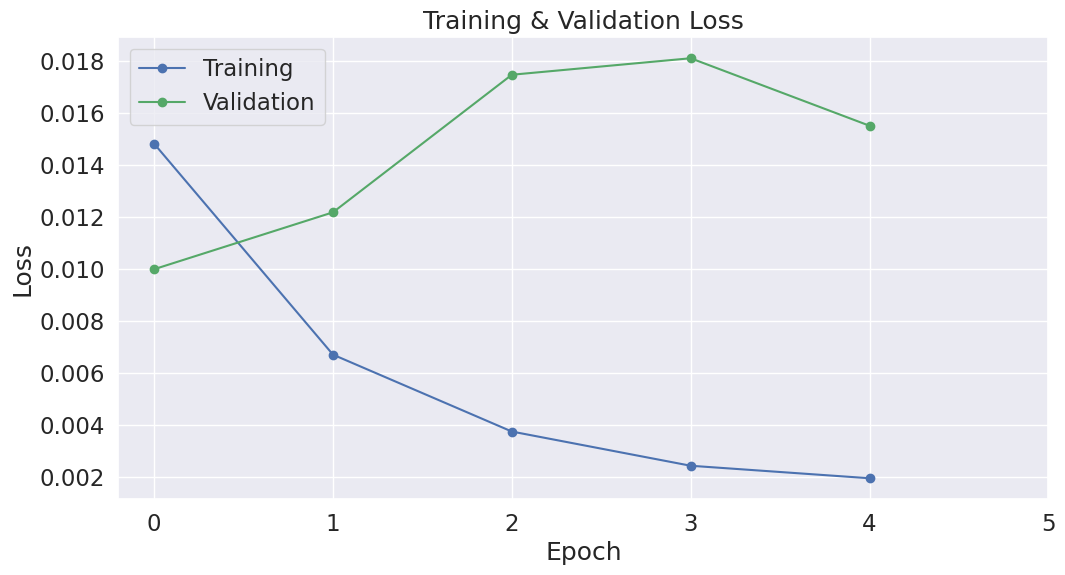

In [ ]:
#  Plot loss
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([0, 1, 2, 3, 4, 5])
plt.show()

In [ ]:
test

In [ ]:
# Cleaning text
test['text_cleaned'] = list(map(lambda x:  preprocess_sentence_english(x),test['text']) )

# Get the lists of sentences and their labels
sentences = test.text_cleaned.values

# input_ids = torch.from_numpy(input_ids)
# attention_masks = torch.tensor(attention_masks)
# labels = torch.tensor(labels)

test_input_ids = tokenize_inputs(sentences, tokenizer, num_embeddings=120)
test_attention_masks = create_attn_masks(test_input_ids)

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [ ]:
def generate_predictions(model, df, device="cpu", batch_size=16):
  num_iter = math.ceil(df.shape[0]/batch_size)

  pred_probs = []

  #model.to(device)
  #model.eval()

  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
#       pred_probs = np.vstack([pred_probs, logits])
      pred_probs.extend(logits.tolist())

  return pred_probs

In [ ]:
import statistics

In [ ]:
pred_probs = generate_predictions(model, test, device="cuda", batch_size=16)
# pred_probs
statistics.mean(pred_probs)

0.37171695376237784

In [ ]:
test['target'] = pred_probs
test['target'] = np.array(test['target'] >= 0.5, dtype='int')

In [ ]:
auc_value = roc_auc_score(test['isHate'], np.asarray(pred_probs) >0.5)
print("auc  on test {}".format(auc_value))

auc  on test 0.9528254693256121


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from numpy import trapz
from scipy.integrate import simps
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score,balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score,cohen_kappa_score

In [ ]:
def Evaluate(labels, predictions, p=0.5):
    CM= confusion_matrix(labels, predictions > p)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    print(' (True Negatives): {}'.format(TN))
    print(' (False Negatives):  {}'.format(FN))
    print(' (True Positives): {}'.format(TP))
    print('(False Positives):{}'.format(FP))
    print('Total positive : ', np.sum(CM[1]))
    auc = roc_auc_score(labels, predictions)
    norm_acc = accuracy_score(labels, predictions)
    prec=precision_score(labels, predictions>0.5)
    rec=recall_score(labels, predictions>0.5)
     # calculate F1 score
    f1 = f1_score(labels, predictions>p)
    print('auc :{}'.format(auc))
    print('precision :{}'.format(prec))
    print('recall :{}'.format(rec))
    print('f1 :{}'.format(f1))
    # Compute Precision-Recall and plot curve
    precision, recall, thresholds = precision_recall_curve(labels, predictions >0.5)
    #use the trapezoidal rule to calculate the area under the precion-recall curve
    area =  trapz(recall, precision)

    #area =  simps(recall, precision)
    print("Area Under Precision Recall  Curve(AP): %0.4f" % area)   #should be same as AP?
    average_precision = average_precision_score(labels, predictions>0.5)
    print("average precision: %0.4f" % average_precision)
    kappa = cohen_kappa_score(labels, predictions>0.5)
    print('kappa :{}'.format(kappa))
    print('Accuracy :{}'.format(norm_acc))

    return (auc, prec, rec, f1, average_precision, kappa, norm_acc)


Evaluate(test['isHate'], np.asarray(pred_probs) >0.5)

 (True Negatives): 764
 (False Negatives):  28
 (True Positives): 437
(False Positives):27
Total positive :  465
auc :0.9528254693256121
precision :0.9418103448275862
recall :0.9397849462365592
f1 :0.9407965554359526
Area Under Precision Recall  Curve(AP): 0.5817
average precision: 0.9074
kappa :0.9060524626549019
Accuracy :0.9562101910828026


(0.9528254693256121,
 0.9418103448275862,
 0.9397849462365592,
 0.9407965554359526,
 0.9073921779094016,
 0.9060524626549019,
 0.9562101910828026)

In [ ]:
df['isHate'].value_counts()

0    5302
1    3071
Name: isHate, dtype: int64

AttributeError: ignored

In [ ]:
for train_index, val_index in kf.split(df):
    print(df.iloc[val_index])
    break

       isHate                                               text  token_length
10701       0                   Had my covid vaccine today. Yay!            13
6415        0  I got my 1st dose of the covid vaccine this mo...            21
10259       1  I've been thinking about getting the vaccine a...            50
7825        0  Got my 2nd Pfizer shot, let's gooo. 2 weeks un...            36
6918        1  Experimental mRNA gene therapy is not a Vaccin...            50
...       ...                                                ...           ...
8668        1  Did you know that the pharmaceutical companies...            47
9747        1  “The NWO Perpetrators of the\nCoronavirus Pand...            47
10221       0  I got my first dose, and now I feel invincible...            55
10466       0  I went searching the #covid19mb walk-in clinic...            47
9292        1  In case you need to hear this:\n\nViral Vector...            51

[1675 rows x 3 columns]


In [ ]:
for train_index, val_index in kf.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]

    train['text_cleaned'] = list(map(lambda x: preprocess_sentence_english(x),train['text']) )
    test['text_cleaned'] = list(map(lambda x: preprocess_sentence_english(x),test['text']) )

    sentences = train.text_cleaned.values
    labels = train.isHate.values

    input_ids = tokenize_inputs(sentences, tokenizer, num_embeddings=120)
    attention_masks = create_attn_masks(input_ids)

    # Convert the lists into tensors.
    # input_ids = torch.cat(input_ids, dim=0)
    # attention_masks = torch.cat(attention_masks, dim=0)
    input_ids = torch.from_numpy(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)

    # Combine the training inputs into a TensorDataset.
    dataset = TensorDataset(input_ids, attention_masks, labels)

    # Create a 80-20 train-validation split.

    # Calculate the number of samples to include in each set.
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Checking whether the distribution of target is consitent across both the sets
    label_temp_list = []
    for a,b,c in train_dataset:
        label_temp_list.append(c)

    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} training samples with hate speech'.format(sum(label_temp_list)))

    label_temp_list = []
    for a,b,c in val_dataset:
        label_temp_list.append(c)

    # The DataLoader needs to know our batch size for training, so we specify it
    # here. Batch size of 16 or 32.
    batch_size = 16

    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order.
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )

    torch.cuda.empty_cache()

    num_epochs = 5
    cwd = os.getcwd()
    model, train_loss_set, valid_loss_set, training_stats = train_model(model=model,\
                                                              num_epochs=num_epochs,\
                                                              optimizer=optimizer,\
                                                              train_dataloader=train_dataloader,\
                                                              valid_dataloader=validation_dataloader,\
                                                              device="cuda"
                                                              )

    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    test['text_cleaned'] = list(map(lambda x:  preprocess_sentence_english(x),test['text']) )

    # Get the lists of sentences and their labels
    sentences = test.text_cleaned.values

    # input_ids = torch.from_numpy(input_ids)
    # attention_masks = torch.tensor(attention_masks)
    # labels = torch.tensor(labels)

    test_input_ids = tokenize_inputs(sentences, tokenizer, num_embeddings=120)
    test_attention_masks = create_attn_masks(test_input_ids)

    test["features"] = test_input_ids.tolist()
    test["masks"] = test_attention_masks

    pred_probs = generate_predictions(model, test, device="cuda", batch_size=16)
# pred_probs

    statistics.mean(pred_probs)

    test['target'] = pred_probs
    test['target'] = np.array(test['target'] >= 0.5, dtype='int')

    auc_value = roc_auc_score(test['isHate'], np.asarray(pred_probs) >0.5)
    print("auc  on test {}".format(auc_value))

    results.append(Evaluate(test['isHate'], np.asarray(pred_probs) >0.5))

6,028 training samples
2,244 training samples with hate speech


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 0 / 5 ========
Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
for i, vals in enumerate(results):
    print(f'------------ K = {i} ------------------')
    print('AUC Score - ', vals[0])
    print('Precision - ', vals[1])
    print('Recall - ', vals[2])
    print('F1 Score - ', vals[3])
    print('Precision', vals[4])
    print('Kappa - ', vals[5])
    print("Accuracy", vals[6])
    print("Norm Accuracy", vals[7])
    print("\n")

NameError: ignored